# Predict Tracks in Graphs with Edges

#### Features:
  - Node  : $[x, y] + $ `[0, 0, 1, 0, 0, 0]` i.e. coordinate + layers
  - Edge  : `dist` $ + [u_x, u_y] + [v_x, v_y] + layer_u + layer_v$ i.e. distance + start_coordinate + end_coordinate + start_layers + end_layers

#### Labels:
  - Edge : `[0, 1]` for track-edge and `[1, 0]` otherwise

In [1]:
PATH_PREFIX = '../'
DATA_DIR = 'Combined_Parsed/'
MODEL_SAVE_DIR = 'Model(Track)/'
DATA_FILE_PATH = PATH_PREFIX + DATA_DIR + 'dataset_{:04d}.json'

In [2]:
#@title Imports

import sys
sys.path.append(PATH_PREFIX)

from __future__ import absolute_import, division, print_function

from graphGenerator import to_graph_dict_with_edges

import collections
import ujson
import time

from graph_nets import utils_np, utils_tf
import modelTrack as model

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

In [3]:
#@title Helper functions


def get_node_pos(graph):
    return {
        k: np.array([v['features'][0], v['features'][1]])
        for k, v in graph.node.items()
    }


def generate_dict_graphs(raw_data, offset, batch_size):
    """Generate graphs for training.
    
    Args:
        raw_data: The list of raw data objects.
        offset: Starting index to pick from the `raw_data`.
        batch_size: Total number of graphs per batch.
        
    Returns:
        input_graph_dict: An input graph in dictionary format.
        target_graph_dict: A labelled input graph in dictionary format.
    """
    input_graphs, target_graphs, raw_graphs = [], [], []
    for i in range(offset, offset + batch_size):
        input_graph_dict, target_graph_dict, raw_graph, min_dist, max_dist = to_graph_dict_with_edges(
            raw_data[i])
        input_graphs.append(input_graph_dict)
        target_graphs.append(target_graph_dict)
        raw_graphs.append({
            'raw-graph': raw_graph,
            'min-dist': min_dist,
            'max-dist': max_dist
        })
    return input_graphs, target_graphs, raw_graphs


def create_placeholders(raw_data, offset, batch_size):
    """Creates placeholders for the model training and evaluation.

  Args:
    raw_data: The list of raw data objects.
    offset: Starting index to pick from the `raw_data`.
    batch_size: Total number of graphs per batch.

  Returns:
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.
  """
    # Create some example data for inspecting the vector sizes.
    input_graphs, target_graphs, _ = generate_dict_graphs(
        raw_data, offset, batch_size)
    input_ph = utils_tf.placeholders_from_data_dicts(input_graphs)
    target_ph = utils_tf.placeholders_from_data_dicts(target_graphs)

    return input_ph, target_ph


def create_feed_dict(raw_data, offset, batch_size, input_ph, target_ph):
    """Creates placeholders for the model training and evaluation.

  Args:
    raw_data: The list of raw data objects.
    offset: Starting index to pick from the `raw_data`.
    batch_size: Total number of graphs per batch.
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.

  Returns:
    feed_dict: The feed `dict` of input and target placeholders and data.
    raw_graphs: The `dict` of raw graphs.
  """
    inputs, targets, raw_graphs = generate_dict_graphs(raw_data, offset,
                                                       batch_size)
    input_graphs = utils_np.data_dicts_to_graphs_tuple(inputs)
    target_graphs = utils_np.data_dicts_to_graphs_tuple(targets)
    feed_dict = {input_ph: input_graphs, target_ph: target_graphs}

    return feed_dict, raw_graphs


def compute_accuracy(target, output, use_only_track_edges=False):
    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        xn = np.argmax(td['edges'], axis=-1)
        yn = np.argmax(od['edges'], axis=-1)
        c = []
        if use_only_track_edges:
            c.append((xn == yn)[xn > 0])
        else:
            c.append(xn == yn)
        c = np.concatenate(c, axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(ss)
    return correct, solved


def create_loss_ops(target_op, output_ops):
    loss_ops = [
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


class GraphPlotter(object):
    def __init__(self, graph, target, pos, style={}):
        self._graph = graph
        self._target = target
        self._pos = pos
        self._base_draw_kwargs = dict(G=self._graph, pos=self._pos)
        self._nodes = None
        self._edges = None
        self._track_edges = None
        self._non_track_edges = None

    @property
    def nodes(self):
        if self._nodes is None:
            self._nodes = self._graph.nodes()
        return self._nodes

    @property
    def edges(self):
        if self._edges is None:
            self._edges = self._graph.edges()
        return self._edges

    @property
    def non_track_edges(self):
        if self._non_track_edges is None:
            self._non_track_edges = [
                e for e in self._target.edges() if self._target.get_edge_data(
                    e[0], e[1])[0]['features'][1] == 0.0
            ]
        return self._track_edges

    @property
    def track_edges(self):
        if self._track_edges is None:
            self._track_edges = [
                e for e in self._target.edges() if self._target.get_edge_data(
                    e[0], e[1])[0]['features'][1] == 1.0
            ]
        return self._track_edges

    def _make_draw_kwargs(self, **kwargs):
        kwargs.update(self._base_draw_kwargs)
        return kwargs

    def _draw(self, draw_function, zorder=None, **kwargs):
        draw_kwargs = self._make_draw_kwargs(**kwargs)
        collection = draw_function(**draw_kwargs)
        if collection is not None and zorder is not None:
            try:
                # This is for compatibility with older matplotlib.
                collection.set_zorder(zorder)
            except AttributeError:
                # This is for compatibility with newer matplotlib.
                collection[0].set_zorder(zorder)
        return collection

    def draw_nodes(self, **kwargs):
        """Useful kwargs: nodelist, node_size, node_color, linewidths."""
        if ("node_color" in kwargs
                and isinstance(kwargs["node_color"], collections.Sequence)
                and len(kwargs["node_color"]) in {3, 4}
                and not isinstance(kwargs["node_color"][0],
                                   (collections.Sequence, np.ndarray))):
            num_nodes = len(kwargs.get("nodelist", self.nodes))
            kwargs["node_color"] = np.tile(
                np.array(kwargs["node_color"])[None], [num_nodes, 1])
        return self._draw(nx.draw_networkx_nodes, **kwargs)

    def draw_edges(self, **kwargs):
        """Useful kwargs: edgelist, width."""
        return self._draw(nx.draw_networkx_edges, **kwargs)

    def draw_graph_with_tracks(self,
                               node_size=20,
                               node_color=(1.0, 1.0, 1.0),
                               edge_width=0.2,
                               edge_color='blue',
                               track_edge_color='green',
                               draw_edge_arrow=False,
                               edge_style='dotted',
                               node_linewidth=0.2):
        node_border_color = (0.0, 0.0, 0.0, 1.0)
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.nodes]
        else:
            c = node_color
        # Plot nodes.
        self.draw_nodes(nodelist=self.nodes,
                        node_size=node_size,
                        node_color=c,
                        linewidths=node_linewidth,
                        edgecolors=node_border_color,
                        zorder=20)

        # Plot non-track edges.
        # self.draw_edges(edgelist=self.non_track_edges, style=edge_style, arrows=draw_edge_arrow, width=edge_width, edge_color=edge_color, zorder=10)

        # Plot track edges.
        self.draw_edges(edgelist=self.track_edges,
                        style=edge_style,
                        arrows=draw_edge_arrow,
                        width=edge_width,
                        edge_color=track_edge_color,
                        zorder=10)

In [ ]:
#@title Visualize example graphs

DATA_FILE_NUMBER = 1
DATA_POINT = 1  # [1 - 100]
SCALE = 4

data_file = open(DATA_FILE_PATH.format(DATA_FILE_NUMBER), 'r')
input_raw_data = ujson.loads(data_file.read())
data_file.close()

input_ph, target_ph = create_placeholders(input_raw_data, DATA_POINT - 1, 1)
feed_dict, raw_graphs = create_feed_dict(input_raw_data, DATA_POINT - 1, 1,
                                         input_ph, target_ph)
input_graphs_tuple, target_graphs_tuple = feed_dict[input_ph], feed_dict[
    target_ph]

# We can visualize the graph using networkx.
input_graphs_nx = utils_np.graphs_tuple_to_networkxs(input_graphs_tuple)[0]
target_graphs_nx = utils_np.graphs_tuple_to_networkxs(target_graphs_tuple)[0]

# print('====================================')

# print(input_graphs_nx[0].graph)
# print(input_graphs_nx[0].nodes)
# print(input_graphs_nx[0].nodes.data())  # or   print(digraph.nodes(data=True))
# print(input_graphs_nx[0].edges)
# print(input_graphs_nx[0].edges.data())
# print('=====================================')

# print(target_graphs_nx[0].graph)
# print(target_graphs_nx[0].nodes)
# print(target_graphs_nx[0].nodes.data())  # or   print(digraph.nodes(data=True))
# print(target_graphs_nx[0].edges)
# print(target_graphs_nx[0].edges.data())

# print('====================================')

print(raw_graphs[0]['min-dist'])
print(raw_graphs[0]['max-dist'])

fig = plt.figure(facecolor='white',
                 figsize=(4 * SCALE, 4 * SCALE),
                 dpi=40 * SCALE)
pos = get_node_pos(input_graphs_nx)
plotter = GraphPlotter(input_graphs_nx, target_graphs_nx, pos)
plotter.draw_graph_with_tracks(draw_edge_arrow=False, edge_style='dotted')

$\displaystyle\text{# files used for training} = \frac{\text{num_training_iterations}\ \ \times\ \ \text{batch_size_tr}}{100}$


$\displaystyle\text{# files used for testing} = \frac{\text{num_training_iterations}\ \ \times\ \ \text{batch_size_ge}}{100\ \ \times\ \ \text{test_after_every_N_training_iterations}}$

In [ ]:
#@title Set up model training and evaluation

tf.reset_default_graph()

DATA_FILE_NUMBER_TR = 1
DATA_FILE_NUMBER_GE = 2500

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps = 10

# Training parameters.
num_training_iterations = 8000
test_after_every_N_training_iterations = 10

batch_size_tr = 25
batch_size_ge = 50

# Data.
training_raw_data = ujson.loads(
    open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_TR), 'r').read())
test_raw_data = ujson.loads(
    open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_GE), 'r').read())

# Input and target placeholders.
input_ph, target_ph = create_placeholders(training_raw_data, 0, batch_size_tr)

# Connect the data to the model.
# Instantiate the model.
model = model.EncodeProcessDecode(edge_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph,
                      num_processing_steps)  # 10 `GraphsTuple` objects
output_ops_ge = model(input_ph,
                      num_processing_steps)  # 10 `GraphsTuple` objects

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Average loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps

# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

In [5]:
#@title Reset session

# This cell resets the Tensorflow session, but keeps the same computational graph.

try:
  sess.close()
except NameError:
  pass
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []
training_data_file_current_offset, test_data_file_current_offset = 0, 0

In [6]:
#@title Run training

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
for iteration in range(1, num_training_iterations + 1):
    feed_dict, _ = create_feed_dict(training_raw_data,
                                    training_data_file_current_offset,
                                    batch_size_tr, input_ph, target_ph)
    train_values = sess.run(
        {
            "step": step_op,
            "target": target_ph,
            "loss": loss_op_tr,
            "outputs": output_ops_tr
        },
        feed_dict=feed_dict)

    if iteration % test_after_every_N_training_iterations == 0:
        elapsed_time = time.time() - start_time
        try:
            feed_dict, _ = create_feed_dict(test_raw_data,
                                            test_data_file_current_offset,
                                            batch_size_ge, input_ph, target_ph)
            test_values = sess.run(
                {
                    "target": target_ph,
                    "loss": loss_op_ge,
                    "inputs": input_ph,
                    "outputs": output_ops_ge
                },
                feed_dict=feed_dict)
        except Exception as e:
            print(
                'skipped file #{} (offset {}) because of exception: {}'.format(
                    DATA_FILE_NUMBER_GE, test_data_file_current_offset, e))
        else:
            correct_tr, solved_tr = compute_accuracy(
                train_values["target"],
                train_values["outputs"][-1],
                use_only_track_edges=True)
            correct_ge, solved_ge = compute_accuracy(
                test_values["target"],
                test_values["outputs"][-1],
                use_only_track_edges=True)
            losses_tr.append(train_values["loss"])
            corrects_tr.append(correct_tr)
            solveds_tr.append(solved_tr)
            losses_ge.append(test_values["loss"])
            corrects_ge.append(correct_ge)
            solveds_ge.append(solved_ge)
            logged_iterations.append(iteration)
            print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, Str"
                  " {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
                      iteration, elapsed_time, train_values["loss"],
                      test_values["loss"], correct_tr, solved_tr, correct_ge,
                      solved_ge))
        finally:
            test_data_file_current_offset += batch_size_ge
            test_data_file_current_offset %= 100
            if test_data_file_current_offset == 0:
                DATA_FILE_NUMBER_GE += 1
                test_raw_data = ujson.loads(
                    open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_GE),
                         'r').read())
            start_time = time.time()
    training_data_file_current_offset += batch_size_tr
    training_data_file_current_offset %= 100
    if training_data_file_current_offset == 0:
        DATA_FILE_NUMBER_TR += 1
        training_raw_data = ujson.loads(
            open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_TR), 'r').read())

save_path = saver.save(sess, PATH_PREFIX + MODEL_SAVE_DIR + 'model.ckpt')
print('Model saved in path: %s' % save_path)

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00010, T 41.1, Ltr 0.1106, Lge 0.1208, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00020, T 34.9, Ltr 0.0808, Lge 0.1001, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00030, T 32.9, Ltr 0.0743, Lge 0.1099, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00040, T 33.4, Ltr 0.0848, Lge 0.1163, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00050, T 34.6, Ltr 0.0748, Lge 0.1086, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00060, T 31.4, Ltr 0.0788, Lge 0.1046, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00070, T 32.7, Ltr 0.1000, Lge 0.1246, Ctr 0.0000, Str 0.0000, Cge 0.0000, Sge 0.0000
# 00080, T 31.6, Ltr 0.0883, Lge 0.0990, Ctr 0.0000, St

# 00910, T 34.5, Ltr 0.0188, Lge 0.0255, Ctr 0.6999, Str 0.0400, Cge 0.8494, Sge 0.1000
# 00920, T 34.2, Ltr 0.0192, Lge 0.0193, Ctr 0.8541, Str 0.0000, Cge 0.8578, Sge 0.1400
# 00930, T 30.6, Ltr 0.0204, Lge 0.0195, Ctr 0.8156, Str 0.0800, Cge 0.8372, Sge 0.1600
# 00940, T 35.6, Ltr 0.0184, Lge 0.0234, Ctr 0.7945, Str 0.0000, Cge 0.8399, Sge 0.2200
# 00950, T 31.8, Ltr 0.0180, Lge 0.0204, Ctr 0.8342, Str 0.0800, Cge 0.8554, Sge 0.1200
# 00960, T 35.0, Ltr 0.0179, Lge 0.0186, Ctr 0.8268, Str 0.0400, Cge 0.8481, Sge 0.1600
# 00970, T 35.0, Ltr 0.0191, Lge 0.0188, Ctr 0.8262, Str 0.1200, Cge 0.8302, Sge 0.1000
# 00980, T 36.0, Ltr 0.0172, Lge 0.0203, Ctr 0.7948, Str 0.0000, Cge 0.8483, Sge 0.0800
# 00990, T 36.8, Ltr 0.0196, Lge 0.0207, Ctr 0.7817, Str 0.0000, Cge 0.8559, Sge 0.1600
# 01000, T 36.2, Ltr 0.0199, Lge 0.0185, Ctr 0.8219, Str 0.0000, Cge 0.8342, Sge 0.1400
# 01010, T 34.7, Ltr 0.0180, Lge 0.0215, Ctr 0.8056, Str 0.0000, Cge 0.8615, Sge 0.1400
# 01020, T 31.5, Ltr 0.0224, Lge

# 01840, T 34.1, Ltr 0.0150, Lge 0.0170, Ctr 0.8449, Str 0.0800, Cge 0.8817, Sge 0.1600
# 01850, T 35.7, Ltr 0.0143, Lge 0.0168, Ctr 0.8046, Str 0.0000, Cge 0.8567, Sge 0.2000
# 01860, T 31.7, Ltr 0.0148, Lge 0.0157, Ctr 0.8522, Str 0.0400, Cge 0.8605, Sge 0.1200
# 01870, T 33.2, Ltr 0.0170, Lge 0.0163, Ctr 0.8222, Str 0.0000, Cge 0.8396, Sge 0.1000
skipped file #2593 (offset 50) because of exception: all the input arrays must have same number of dimensions
# 01890, T 29.4, Ltr 0.0162, Lge 0.0154, Ctr 0.8587, Str 0.1200, Cge 0.8959, Sge 0.1400
# 01900, T 32.6, Ltr 0.0163, Lge 0.0224, Ctr 0.8807, Str 0.1600, Cge 0.8654, Sge 0.0800
skipped file #2595 (offset 0) because of exception: all the input arrays must have same number of dimensions
# 01920, T 33.4, Ltr 0.0149, Lge 0.0145, Ctr 0.8325, Str 0.0400, Cge 0.8674, Sge 0.0800
# 01930, T 32.4, Ltr 0.0143, Lge 0.0160, Ctr 0.8728, Str 0.0400, Cge 0.8466, Sge 0.0600
# 01940, T 31.9, Ltr 0.0164, Lge 0.0185, Ctr 0.8126, Str 0.0000, Cge 0.8646, 

# 02770, T 32.9, Ltr 0.0138, Lge 0.0109, Ctr 0.9269, Str 0.0400, Cge 0.9301, Sge 0.2200
# 02780, T 36.2, Ltr 0.0101, Lge 0.0113, Ctr 0.9141, Str 0.0000, Cge 0.9338, Sge 0.2400
# 02790, T 35.3, Ltr 0.0121, Lge 0.0124, Ctr 0.9119, Str 0.0400, Cge 0.9174, Sge 0.1000
# 02800, T 33.1, Ltr 0.0126, Lge 0.0105, Ctr 0.9175, Str 0.0400, Cge 0.9232, Sge 0.2400
skipped file #2640 (offset 0) because of exception: all the input arrays must have same number of dimensions
# 02820, T 34.3, Ltr 0.0123, Lge 0.0109, Ctr 0.8935, Str 0.0800, Cge 0.9086, Sge 0.2200
# 02830, T 36.6, Ltr 0.0100, Lge 0.0107, Ctr 0.9008, Str 0.1200, Cge 0.9237, Sge 0.2200
# 02840, T 33.9, Ltr 0.0122, Lge 0.0094, Ctr 0.8909, Str 0.0800, Cge 0.9385, Sge 0.1600
# 02850, T 30.0, Ltr 0.0123, Lge 0.0113, Ctr 0.8968, Str 0.1200, Cge 0.9203, Sge 0.2200
# 02860, T 35.6, Ltr 0.0116, Lge 0.0100, Ctr 0.8952, Str 0.0000, Cge 0.9217, Sge 0.1200
# 02870, T 33.3, Ltr 0.0107, Lge 0.0129, Ctr 0.9041, Str 0.0000, Cge 0.9197, Sge 0.3400
# 02880, T 

# 03700, T 32.5, Ltr 0.0102, Lge 0.0068, Ctr 0.9153, Str 0.1200, Cge 0.9604, Sge 0.3600
# 03710, T 33.4, Ltr 0.0095, Lge 0.0072, Ctr 0.9362, Str 0.0800, Cge 0.9479, Sge 0.3000
# 03720, T 32.3, Ltr 0.0101, Lge 0.0095, Ctr 0.9316, Str 0.0800, Cge 0.9246, Sge 0.3400
# 03730, T 32.9, Ltr 0.0100, Lge 0.0090, Ctr 0.9067, Str 0.0400, Cge 0.9392, Sge 0.2600
# 03740, T 33.0, Ltr 0.0103, Lge 0.0085, Ctr 0.9357, Str 0.0800, Cge 0.9444, Sge 0.2400
# 03750, T 36.3, Ltr 0.0099, Lge 0.0074, Ctr 0.9426, Str 0.1200, Cge 0.9219, Sge 0.1800
# 03760, T 33.2, Ltr 0.0113, Lge 0.0074, Ctr 0.9253, Str 0.0800, Cge 0.9457, Sge 0.3600
# 03770, T 34.1, Ltr 0.0104, Lge 0.0069, Ctr 0.9122, Str 0.0400, Cge 0.9452, Sge 0.2000
# 03780, T 33.9, Ltr 0.0106, Lge 0.0116, Ctr 0.9255, Str 0.1200, Cge 0.9282, Sge 0.2000
# 03790, T 34.2, Ltr 0.0110, Lge 0.0076, Ctr 0.9245, Str 0.0800, Cge 0.9470, Sge 0.3400
# 03800, T 31.8, Ltr 0.0124, Lge 0.0072, Ctr 0.9428, Str 0.2800, Cge 0.9510, Sge 0.2200
# 03810, T 34.4, Ltr 0.0094, Lge

# 04630, T 37.9, Ltr 0.0092, Lge 0.0069, Ctr 0.9383, Str 0.0400, Cge 0.9386, Sge 0.3200
# 04640, T 31.6, Ltr 0.0086, Lge 0.0068, Ctr 0.9475, Str 0.1200, Cge 0.9375, Sge 0.2400
# 04650, T 37.5, Ltr 0.0090, Lge 0.0056, Ctr 0.9356, Str 0.1200, Cge 0.9608, Sge 0.3000
# 04660, T 37.6, Ltr 0.0084, Lge 0.0069, Ctr 0.9259, Str 0.1600, Cge 0.9495, Sge 0.3800
# 04670, T 36.3, Ltr 0.0102, Lge 0.0069, Ctr 0.9168, Str 0.0000, Cge 0.9410, Sge 0.3200
# 04680, T 33.5, Ltr 0.0115, Lge 0.0099, Ctr 0.9212, Str 0.1200, Cge 0.9207, Sge 0.2400
# 04690, T 36.1, Ltr 0.0097, Lge 0.0081, Ctr 0.9462, Str 0.2800, Cge 0.9333, Sge 0.2600
# 04700, T 34.6, Ltr 0.0088, Lge 0.0068, Ctr 0.9297, Str 0.0800, Cge 0.9423, Sge 0.2200
# 04710, T 36.5, Ltr 0.0087, Lge 0.0065, Ctr 0.9372, Str 0.1600, Cge 0.9412, Sge 0.3200
# 04720, T 35.5, Ltr 0.0083, Lge 0.0072, Ctr 0.9413, Str 0.1200, Cge 0.9501, Sge 0.3000
# 04730, T 33.9, Ltr 0.0104, Lge 0.0060, Ctr 0.9329, Str 0.0400, Cge 0.9480, Sge 0.2600
# 04740, T 34.0, Ltr 0.0076, Lge

# 05560, T 35.6, Ltr 0.0080, Lge 0.0066, Ctr 0.9354, Str 0.1200, Cge 0.9474, Sge 0.2800
# 05570, T 33.3, Ltr 0.0077, Lge 0.0068, Ctr 0.9468, Str 0.1200, Cge 0.9454, Sge 0.3400
# 05580, T 38.7, Ltr 0.0065, Lge 0.0045, Ctr 0.9509, Str 0.0800, Cge 0.9671, Sge 0.4200
# 05590, T 37.3, Ltr 0.0070, Lge 0.0055, Ctr 0.9545, Str 0.2400, Cge 0.9531, Sge 0.3600
# 05600, T 36.2, Ltr 0.0070, Lge 0.0067, Ctr 0.9666, Str 0.1600, Cge 0.9550, Sge 0.4000
# 05610, T 32.9, Ltr 0.0080, Lge 0.0083, Ctr 0.9415, Str 0.2000, Cge 0.9596, Sge 0.4400
# 05620, T 36.4, Ltr 0.0072, Lge 0.0044, Ctr 0.9445, Str 0.1200, Cge 0.9575, Sge 0.3600
# 05630, T 34.2, Ltr 0.0079, Lge 0.0053, Ctr 0.9429, Str 0.2000, Cge 0.9564, Sge 0.3800
# 05640, T 35.9, Ltr 0.0083, Lge 0.0064, Ctr 0.9464, Str 0.1600, Cge 0.9570, Sge 0.3000
# 05650, T 34.2, Ltr 0.0076, Lge 0.0079, Ctr 0.9559, Str 0.2000, Cge 0.9415, Sge 0.2000
# 05660, T 40.1, Ltr 0.0081, Lge 0.0081, Ctr 0.9336, Str 0.0800, Cge 0.9311, Sge 0.3000
# 05670, T 37.0, Ltr 0.0083, Lge

# 06490, T 37.8, Ltr 0.0073, Lge 0.0051, Ctr 0.9552, Str 0.1600, Cge 0.9614, Sge 0.4200
# 06500, T 36.1, Ltr 0.0071, Lge 0.0076, Ctr 0.9332, Str 0.1200, Cge 0.9506, Sge 0.3400
# 06510, T 36.1, Ltr 0.0083, Lge 0.0041, Ctr 0.9337, Str 0.2400, Cge 0.9696, Sge 0.5000
# 06520, T 32.2, Ltr 0.0059, Lge 0.0060, Ctr 0.9623, Str 0.2400, Cge 0.9589, Sge 0.3800
# 06530, T 37.1, Ltr 0.0071, Lge 0.0051, Ctr 0.9566, Str 0.1600, Cge 0.9519, Sge 0.4000
# 06540, T 34.3, Ltr 0.0087, Lge 0.0072, Ctr 0.9361, Str 0.1600, Cge 0.9519, Sge 0.3800
# 06550, T 32.5, Ltr 0.0085, Lge 0.0066, Ctr 0.9391, Str 0.2400, Cge 0.9507, Sge 0.4200
skipped file #2827 (offset 50) because of exception: all the input arrays must have same number of dimensions
# 06570, T 36.2, Ltr 0.0069, Lge 0.0042, Ctr 0.9464, Str 0.1600, Cge 0.9619, Sge 0.4200
# 06580, T 36.4, Ltr 0.0075, Lge 0.0055, Ctr 0.9472, Str 0.0400, Cge 0.9622, Sge 0.5200
# 06590, T 30.3, Ltr 0.0077, Lge 0.0046, Ctr 0.9566, Str 0.3200, Cge 0.9670, Sge 0.4800
# 06600, T

# 07420, T 36.4, Ltr 0.0065, Lge 0.0065, Ctr 0.9560, Str 0.2400, Cge 0.9554, Sge 0.4200
# 07430, T 33.5, Ltr 0.0066, Lge 0.0053, Ctr 0.9706, Str 0.2000, Cge 0.9538, Sge 0.3000
# 07440, T 40.5, Ltr 0.0079, Lge 0.0044, Ctr 0.9391, Str 0.0000, Cge 0.9741, Sge 0.5000
# 07450, T 34.0, Ltr 0.0066, Lge 0.0046, Ctr 0.9674, Str 0.3600, Cge 0.9446, Sge 0.4200
# 07460, T 35.2, Ltr 0.0053, Lge 0.0049, Ctr 0.9646, Str 0.2000, Cge 0.9497, Sge 0.3000
# 07470, T 33.8, Ltr 0.0078, Lge 0.0061, Ctr 0.9498, Str 0.3600, Cge 0.9565, Sge 0.2600
# 07480, T 35.1, Ltr 0.0077, Lge 0.0036, Ctr 0.9512, Str 0.1600, Cge 0.9684, Sge 0.5600
# 07490, T 32.0, Ltr 0.0059, Lge 0.0037, Ctr 0.9662, Str 0.3200, Cge 0.9648, Sge 0.5000
# 07500, T 32.9, Ltr 0.0071, Lge 0.0056, Ctr 0.9489, Str 0.0800, Cge 0.9506, Sge 0.3400
# 07510, T 36.8, Ltr 0.0061, Lge 0.0040, Ctr 0.9559, Str 0.1200, Cge 0.9663, Sge 0.4200
# 07520, T 36.7, Ltr 0.0083, Lge 0.0040, Ctr 0.9051, Str 0.1200, Cge 0.9707, Sge 0.4200
# 07530, T 34.2, Ltr 0.0071, Lge

Text(0,0.5,'Fraction examples solved')

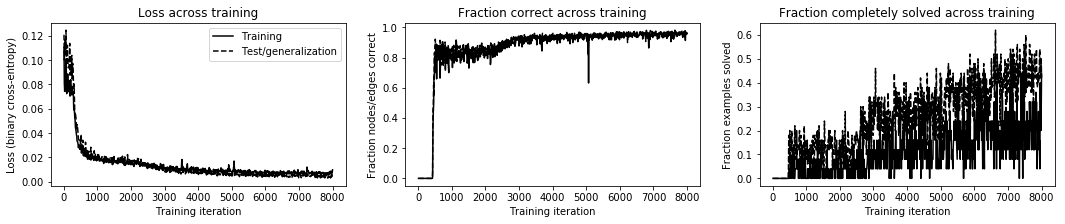

In [7]:
#@title Visualize results

fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction completely solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")